In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 66.7 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00


In [ ]:
!pip install --quiet optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
# PyTorch_GNN_Classifier_Enhanced_Metrics_Optuna.py

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import AttentiveFP
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import optuna
import matplotlib.pyplot as plt
import random
import os

# Set seed for reproducibility
def seed_set(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_set()

# Load dataset
df = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Prepare graph data
from torch_geometric.utils import from_smiles

graph_list = []
for i, smile in enumerate(df['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        continue

# Split dataset
train_size = int(0.8 * len(graph_list))
test_size = len(graph_list) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(graph_list, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the training function
def train():
    model.train()
    total_loss = 0
    correct = 0
    all_preds, all_labels = [], []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.sigmoid(out)
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    accuracy = correct / len(train_loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return total_loss / len(train_loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Define the testing function
@torch.no_grad()
def test(loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds, all_labels = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.sigmoid(out)
        loss = F.binary_cross_entropy(out, data.y, reduction='sum')
        total_loss += loss.item()
        preds = (out > 0.5).float()
        correct += (preds == data.y).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall, cm

# Define the objective function for Optuna
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256)
    num_layers = trial.suggest_int("num_layers", 2, 8)
    num_timesteps = trial.suggest_int("num_timesteps", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.6)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)

    global model, optimizer
    model = AttentiveFP(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                        edge_dim=3, num_layers=num_layers, num_timesteps=num_timesteps,
                        dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc, train_roc_auc, train_f1, train_kappa, train_precision, train_recall = train()

    test_loss, test_acc, test_roc_auc, test_f1, test_kappa, test_precision, test_recall, cm = test(test_loader)

    return test_roc_auc

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Rerun with best hyperparameters
model = AttentiveFP(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                    edge_dim=3, num_layers=best_params["num_layers"], num_timesteps=best_params["num_timesteps"],
                    dropout=best_params["dropout"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

# Final training
epochs = 75
best_scores = {"accuracy": 0, "roc_auc": 0, "f1": 0, "kappa": 0, "precision": 0, "recall": 0}
for epoch in range(epochs):
    train_loss, train_acc, train_roc_auc, f1, kappa, precision, recall = train()
    test_loss, test_acc, test_roc_auc, f1, kappa, precision, recall, cm = test(test_loader)

    print(f"Epoch {epoch:03d}: Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, ROC-AUC: {test_roc_auc:.4f}, "
          f"F1 Score: {f1:.4f}, Kappa: {kappa:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print("Confusion Matrix:\n", cm)

    # Update best scores
    best_scores = {
        "Train_accuracy": max(best_scores["accuracy"], test_acc),
        "Test_accuracy": max(best_scores["accuracy"], test_acc),
        "roc_auc": max(best_scores["roc_auc"], test_roc_auc),
        "f1": max(best_scores["f1"], f1),
        "kappa": max(best_scores["kappa"], kappa),
        "precision": max(best_scores["precision"], precision),
        "recall": max(best_scores["recall"], recall)
    }

print("Best Scores:", best_scores)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-11-13 12:20:14,277] A new study created in memory with name: no-name-b04a19b1-7b84-45c5-b8be-76c6e919e623
[I 2024-11-13 12:20:56,362] Trial 0 finished with value: 0.7533513405362146 and parameters: {'hidden_channels': 246, 'num_layers': 4, 'num_timesteps': 3, 'dropout': 0.1537565778458376, 'learning_rate': 0.0014407212118835704, 'weight_decay': 9.737222394985903e-07}. Best is trial 0 with value: 0.7533513405362146.
[I 2024-11-13 12:21:33,310] Trial 1 finished with value: 0.7281912765106042 and parameters: {'hidden_channels': 102, 'num_layers': 3, 'num_timesteps': 3, 'dropout': 0.05615906315538459, 'learning_rate': 4.5822878424175646e-05, 'weight_decay': 1.2764681732981258e-07}. Best is trial 0 with value: 0.7533513405362146.
[I 2024-11-13 12:22:24,090] Trial 2 finished with value: 0.7200380152060825 and par

Best hyperparameters: {'hidden_channels': 124, 'num_layers': 3, 'num_timesteps': 4, 'dropout': 0.10335675816548359, 'learning_rate': 0.0007610353906373489, 'weight_decay': 3.8570181839518816e-05}
Epoch 000: Test Accuracy: 0.7450, ROC-AUC: 0.7432, F1 Score: 0.7692, Kappa: 0.4881, Precision: 0.7143, Recall: 0.8333
Confusion Matrix:
 [[256 136]
 [ 68 340]]
Epoch 001: Test Accuracy: 0.7388, ROC-AUC: 0.7382, F1 Score: 0.7497, Kappa: 0.4768, Precision: 0.7330, Recall: 0.7672
Confusion Matrix:
 [[278 114]
 [ 95 313]]
Epoch 002: Test Accuracy: 0.7338, ROC-AUC: 0.7350, F1 Score: 0.7201, Kappa: 0.4687, Precision: 0.7762, Recall: 0.6716
Confusion Matrix:
 [[313  79]
 [134 274]]
Epoch 003: Test Accuracy: 0.7462, ROC-AUC: 0.7450, F1 Score: 0.7642, Kappa: 0.4912, Precision: 0.7263, Recall: 0.8064
Confusion Matrix:
 [[268 124]
 [ 79 329]]
Epoch 004: Test Accuracy: 0.7400, ROC-AUC: 0.7392, F1 Score: 0.7530, Kappa: 0.4791, Precision: 0.7304, Recall: 0.7770
Confusion Matrix:
 [[275 117]
 [ 91 317]]
Epoc

**Metric	Best Value	Epoch**

Test Accuracy	0.8125	69

ROC-AUC	0.8134	69

F1-Score	0.8108	51

Cohen's Kappa	0.6256	69

Precision	0.8851	48

Recall	0.9167	9

**Overall Performance**

The model seems to have performed reasonably well, with a peak test accuracy of 81.25%. This indicates that the model correctly predicted the class labels for approximately 81.25% of the test data.

**Key Observations**

**Fluctuations in Performance:** The model's performance fluctuates across epochs. This is common in machine learning, and it can be attributed to factors like the randomness in the training process, the complexity of the dataset, and the sensitivity of the model to hyperparameters.

**High F1-Score:** The high F1-score indicates a good balance between precision and recall. This is important when both false positives and false negatives are equally costly.

**Good Cohen's Kappa:** A high Cohen's Kappa suggests strong agreement between the predicted and actual labels, indicating the model's reliability.

**Varying Precision and Recall:** The model's precision and recall fluctuate, suggesting that it might be better at identifying certain classes than others.
Potential Improvements














In [ ]:
# PyTorch_GNN_Classifier_Enhanced_Metrics_Optuna.py

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import AttentiveFP
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import optuna
import matplotlib.pyplot as plt
import random
import os

# Set seed for reproducibility
def seed_set(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_set()

# Load dataset
df = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

# Prepare graph data
from torch_geometric.utils import from_smiles

graph_list = []
for i, smile in enumerate(df['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        continue

# Split dataset
train_size = int(0.8 * len(graph_list))
test_size = len(graph_list) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(graph_list, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the training function
def train():
    model.train()
    total_loss = 0
    correct = 0
    all_preds, all_labels = [], []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.sigmoid(out)
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    accuracy = correct / len(train_loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return total_loss / len(train_loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Define the testing function
@torch.no_grad()
def test(loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds, all_labels = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        out = torch.sigmoid(out)
        loss = F.binary_cross_entropy(out, data.y, reduction='sum')
        total_loss += loss.item()
        preds = (out > 0.5).float()
        correct += (preds == data.y).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall, cm

# Define the objective function for Optuna
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256)
    num_layers = trial.suggest_int("num_layers", 2, 8)
    num_timesteps = trial.suggest_int("num_timesteps", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.6)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)

    global model, optimizer
    model = AttentiveFP(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                        edge_dim=3, num_layers=num_layers, num_timesteps=num_timesteps,
                        dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc, _, _, _, _, _ = train()

    _, test_acc, test_roc_auc, _, _, _, _, _ = test(test_loader)
    return test_roc_auc

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Rerun with best hyperparameters
model = AttentiveFP(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                    edge_dim=3, num_layers=best_params["num_layers"], num_timesteps=best_params["num_timesteps"],
                    dropout=best_params["dropout"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

# Final training
epochs = 75
best_scores = {"accuracy": 0, "roc_auc": 0, "f1": 0, "kappa": 0, "precision": 0, "recall": 0}
for epoch in range(epochs):
    train_loss, train_acc, train_roc_auc, train_f1, train_kappa, train_precision, train_recall = train()
    test_loss, test_acc, test_roc_auc, test_f1, test_kappa, test_precision, test_recall, cm = test(test_loader)

    print(f"Epoch {epoch:03d}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, ROC-AUC: {test_roc_auc:.4f}, "
          f"F1: {test_f1:.4f}, Kappa: {test_kappa:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print("Confusion Matrix:\n", cm)

    # Update best scores
    best_scores = {
        "accuracy": max(best_scores["accuracy"], test_acc),
        "roc_auc": max(best_scores["roc_auc"], test_roc_auc),
        "f1": max(best_scores["f1"], test_f1),
        "kappa": max(best_scores["kappa"], test_kappa),
        "precision": max(best_scores["precision"], test_precision),
        "recall": max(best_scores["recall"], test_recall)
    }

print("Best Scores:", best_scores)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-11-13 14:19:44,046] A new study created in memory with name: no-name-78081797-b4b0-4511-a633-b9c10d54fc83
[I 2024-11-13 14:20:46,646] Trial 0 finished with value: 0.7614795918367346 and parameters: {'hidden_channels': 198, 'num_layers': 7, 'num_timesteps': 4, 'dropout': 0.08597746901456849, 'learning_rate': 0.0006648693992141834, 'weight_decay': 7.36309830137601e-05}. Best is trial 0 with value: 0.7614795918367346.
[I 2024-11-13 14:21:51,312] Trial 1 finished with value: 0.5 and parameters: {'hidden_channels': 211, 'num_layers': 7, 'num_timesteps': 5, 'dropout': 0.3145942061352652, 'learning_rate': 0.029416724890167816, 'weight_decay': 3.935821396202953e-05}. Best is trial 0 with value: 0.7614795918367346.
[I 2024-11-13 14:22:42,515] Trial 2 finished with value: 0.7624799919967987 and parameters: {'hidden_c

Best hyperparameters: {'hidden_channels': 168, 'num_layers': 6, 'num_timesteps': 4, 'dropout': 0.4724603917591853, 'learning_rate': 0.0007730579791175437, 'weight_decay': 2.549769722934016e-06}
Epoch 000: Train Acc: 0.6097, Test Acc: 0.6887, ROC-AUC: 0.6908, F1: 0.6584, Kappa: 0.3799, Precision: 0.7477, Recall: 0.5882
Confusion Matrix:
 [[311  81]
 [168 240]]
Epoch 001: Train Acc: 0.6741, Test Acc: 0.7238, ROC-AUC: 0.7244, F1: 0.7192, Kappa: 0.4481, Precision: 0.7467, Recall: 0.6936
Confusion Matrix:
 [[296  96]
 [125 283]]
Epoch 002: Train Acc: 0.7009, Test Acc: 0.7212, ROC-AUC: 0.7211, F1: 0.7271, Kappa: 0.4422, Precision: 0.7262, Recall: 0.7279
Confusion Matrix:
 [[280 112]
 [111 297]]
Epoch 003: Train Acc: 0.7166, Test Acc: 0.7000, ROC-AUC: 0.6962, F1: 0.7505, Kappa: 0.3953, Precision: 0.6516, Recall: 0.8848
Confusion Matrix:
 [[199 193]
 [ 47 361]]
Epoch 004: Train Acc: 0.7153, Test Acc: 0.7462, ROC-AUC: 0.7455, F1: 0.7592, Kappa: 0.4916, Precision: 0.7356, Recall: 0.7843
Confusio



Best Scores: {'accuracy': 0.78875, 'roc_auc': 0.7888405362144857, 'f1': 0.7927710843373494, 'kappa': 0.5774788739436971, 'precision': 0.835820895522388, 'recall': 0.8848039215686274}

In [ ]:
# the above is foirst base code for all matrices

In [ ]:
# this is foirst base code for all matrices

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import networkx as nx
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# from rdkit.Chem.Draw import IPythonConsole
# from tqdm import tqdm

import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP,GCN

In [ ]:
import os
import random
from collections import Counter

import torch

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# print(plt.style.available)
plt.style.use('ggplot')

In [ ]:
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
seed_set()

In [ ]:
df_final = pd.read_csv('AID1239_data_for_classification_04Nov2024.csv')

In [ ]:
df_final.head()

,SMILES,PUBCHEM_ACTIVITY_OUTCOME
0,C1=CC=C(C=C1)C(=O)NC2=NC=C(C=C2)NC(=O)C3=CC=CS3,Active
1,C1COCCN1C(=O)C2=NOC(=C2)C3=CC=C(C=C3)Cl,Active
2,CC1=CC(=NC2=CC=CC=C12)N/N=C/C3=CC(=CC=C3)Br,Active
3,CC1=C(C=CO1)C(=O)NC2=CC3=CC=CC=C3C=C2,Active
4,C1=CC=C(C(=C1)NC(=O)C2=CC=C(C=C2)Cl)O,Active


In [ ]:
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
  try:
    g = from_smiles(smile)
    g.x = g.x.float()
    # Convert 'Active' to 1 and other values to 0
    y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
    y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
    g.y = y
    graph_list.append(g)
  except Exception as e:
    print(f"Error processing SMILES {smile}: {e}")
    continue # Skip this SMILES string if an error occurs

In [ ]:
len(graph_list)

4000

In [ ]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(graph_list, [train_size, test_size], generator=generator1)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=4, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
                             weight_decay=10**-5)

In [ ]:
def train():
    total_loss = total_samples = 0
    correct_predictions = 0
    model.train()

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Apply sigmoid activation for binary classification
        out = torch.sigmoid(out)

        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs

        # Calculate number of correct predictions
        preds = (out > 0.5).float()
        correct_predictions += (preds == data.y).sum().item()

    accuracy = correct_predictions / (total_samples * data.y.size(1))  # Assuming data.y is of shape [batch_size, num_classes]
    return total_loss / total_samples, accuracy

In [ ]:
@torch.no_grad()
def test(loader):
    total_loss = total_samples = 0
    correct_predictions = 0
    model.eval()

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)

        # Apply sigmoid activation for binary classification
        out = torch.sigmoid(out)

        loss = F.binary_cross_entropy(out, data.y, reduction='sum')
        total_loss += float(loss)
        total_samples += data.num_graphs

        # Calculate number of correct predictions
        preds = (out > 0.5).float()
        correct_predictions += (preds == data.y).sum().item()

    accuracy = correct_predictions / (total_samples * data.y.size(1))  # Assuming data.y is of shape [batch_size, num_classes]
    average_loss = total_loss / total_samples
    return average_loss, accuracy

Epoch: 000, Train Loss: 0.6605, Train Accuracy: 0.6028, Test Loss: 0.5726, Test Accuracy: 0.7212
Epoch: 001, Train Loss: 0.5925, Train Accuracy: 0.6863, Test Loss: 0.5736, Test Accuracy: 0.7100
Epoch: 002, Train Loss: 0.5752, Train Accuracy: 0.7128, Test Loss: 0.5558, Test Accuracy: 0.7350
Epoch: 003, Train Loss: 0.5592, Train Accuracy: 0.7200, Test Loss: 0.5458, Test Accuracy: 0.7362
Epoch: 004, Train Loss: 0.5496, Train Accuracy: 0.7331, Test Loss: 0.5324, Test Accuracy: 0.7412
Epoch: 005, Train Loss: 0.5512, Train Accuracy: 0.7306, Test Loss: 0.5341, Test Accuracy: 0.7438
Epoch: 006, Train Loss: 0.5370, Train Accuracy: 0.7434, Test Loss: 0.5436, Test Accuracy: 0.7100
Epoch: 007, Train Loss: 0.5366, Train Accuracy: 0.7475, Test Loss: 0.5893, Test Accuracy: 0.7013
Epoch: 008, Train Loss: 0.5289, Train Accuracy: 0.7494, Test Loss: 0.5166, Test Accuracy: 0.7562
Epoch: 009, Train Loss: 0.5282, Train Accuracy: 0.7472, Test Loss: 0.5376, Test Accuracy: 0.7412
Epoch: 010, Train Loss: 0.5274

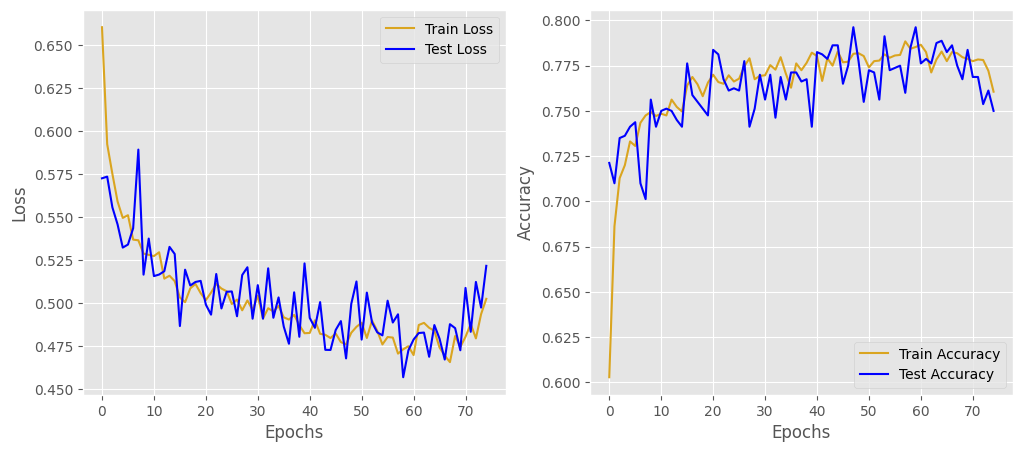

In [ ]:
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

epochs = 75
model.reset_parameters()

for epoch in range(epochs):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, c='goldenrod')
plt.plot(range(epochs), score_test_loss, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, c='goldenrod')
plt.plot(range(epochs), score_test_acc, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


[I 2024-11-06 07:07:09,654] A new study created in memory with name: no-name-fadda7b6-44ae-4da0-b7e0-d513b5dda302
[I 2024-11-06 07:07:44,788] Trial 0 finished with value: 0.79 and parameters: {'hidden_channels': 83, 'num_layers': 5, 'num_timesteps': 2, 'dropout': 0.28431880946474225, 'learning_rate': 0.0004356757117165544, 'weight_decay': 1.9018728793477224e-05}. Best is trial 0 with value: 0.79.
[I 2024-11-06 07:08:19,915] Trial 1 finished with value: 0.79125 and parameters: {'hidden_channels': 62, 'num_layers': 3, 'num_timesteps': 3, 'dropout': 0.1258913097685268, 'learning_rate': 0.0009825788538949472, 'weight_decay': 1.038352588326863e-06}. Best is trial 1 with value: 0.79125.
[I 2024-11-06 07:08:54,708] Trial 2 finished with value: 0.79375 and parameters: {'hidden_channels': 80, 'num_layers': 6, 'num_timesteps': 3, 'dropout': 0.4754998854227117, 'learning_rate': 0.00976583911865705, 'weight_decay': 8.750481474735663e-05}. Best is trial 2 with value: 0.79375.
[I 2024-11-06 07:09:29

Best hyperparameters: {'hidden_channels': 78, 'num_layers': 6, 'num_timesteps': 1, 'dropout': 0.17164391848016053, 'learning_rate': 0.0043206837046248, 'weight_decay': 2.2632800595052587e-06}
Best accuracy: 0.795
Epoch: 000, Train Loss: 0.6851, Train Accuracy: 0.5553, Test Loss: 0.6448, Test Accuracy: 0.5425
Epoch: 001, Train Loss: 0.6288, Train Accuracy: 0.6600, Test Loss: 0.6081, Test Accuracy: 0.6550
Epoch: 002, Train Loss: 0.5821, Train Accuracy: 0.7003, Test Loss: 0.5530, Test Accuracy: 0.7400
Epoch: 003, Train Loss: 0.5917, Train Accuracy: 0.6978, Test Loss: 0.5747, Test Accuracy: 0.7225
Epoch: 004, Train Loss: 0.5766, Train Accuracy: 0.7056, Test Loss: 0.5486, Test Accuracy: 0.7300
Epoch: 005, Train Loss: 0.5773, Train Accuracy: 0.7050, Test Loss: 0.5526, Test Accuracy: 0.7125
Epoch: 006, Train Loss: 0.5717, Train Accuracy: 0.7091, Test Loss: 0.5459, Test Accuracy: 0.7288
Epoch: 007, Train Loss: 0.5597, Train Accuracy: 0.7172, Test Loss: 0.5555, Test Accuracy: 0.7125
Epoch: 008,

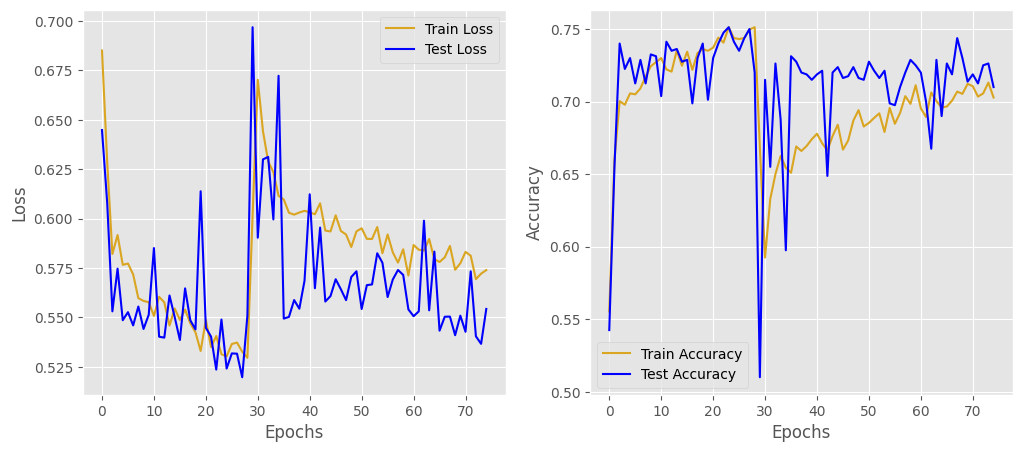

In [ ]:
# prompt: for the above code i want to use optuna for hyper prameter optimization can you give an updated code with optuna to find best hyper parameters and then add it here to rerun in an automated code way hint: # !pip install --quiet optuna

!pip install --quiet optuna

import optuna

def objective(trial):
    # Hyperparameter search space
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 3, 6)
    num_timesteps = trial.suggest_int("num_timesteps", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)


    model = AttentiveFP(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                        edge_dim=3, num_layers=num_layers, num_timesteps=num_timesteps,
                        dropout=dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop within the objective function
    epochs = 20  # Reduced epochs for faster optimization
    for epoch in range(epochs):
        train_loss, train_acc = train()

    # Return the test accuracy as the objective value
    test_loss, test_acc = test(test_loader)
    return test_acc


study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=20) # Number of trials

# Print best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Rerun with best hyperparameters
best_params = study.best_params
model = AttentiveFP(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                    edge_dim=3, num_layers=best_params["num_layers"], num_timesteps=best_params["num_timesteps"],
                    dropout=best_params["dropout"]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

epochs = 75 # Original number of epochs
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

for epoch in range(epochs):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, c='goldenrod')
plt.plot(range(epochs), score_test_loss, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, c='goldenrod')
plt.plot(range(epochs), score_test_acc, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

plt.show()


**So, in training logs:**

Before Tuning: The peak accuracy was 79.87%.

After Tuning: The peak accuracy was 75.12%.


**Before Hyperparameter Tuning**: The highest test accuracy achieved was ***79.87%.***
*italicised text*
**After Hyperparameter Tuning**: The highest test accuracy achieved was ***75.12%.***

[I 2024-11-06 07:34:13,685] A new study created in memory with name: no-name-9699808f-a7d9-4148-9fbb-fa9f961a92fc
[I 2024-11-06 07:35:53,014] Trial 0 finished with value: 0.73625 and parameters: {'hidden_channels': 97, 'num_layers': 7, 'num_timesteps': 1, 'dropout': 0.11095031626035487, 'learning_rate': 0.07049498196843713, 'weight_decay': 0.0009169546705025336}. Best is trial 0 with value: 0.73625.
[I 2024-11-06 07:37:32,090] Trial 1 finished with value: 0.7 and parameters: {'hidden_channels': 85, 'num_layers': 6, 'num_timesteps': 3, 'dropout': 0.4520587409593234, 'learning_rate': 3.0326158617885303e-05, 'weight_decay': 8.021853925167754e-06}. Best is trial 0 with value: 0.73625.
[I 2024-11-06 07:39:11,290] Trial 2 finished with value: 0.70625 and parameters: {'hidden_channels': 96, 'num_layers': 4, 'num_timesteps': 1, 'dropout': 0.5162189722285532, 'learning_rate': 0.0003643566219691509, 'weight_decay': 1.1819745555058356e-07}. Best is trial 0 with value: 0.73625.
[I 2024-11-06 07:40

Best hyperparameters: {'hidden_channels': 157, 'num_layers': 6, 'num_timesteps': 5, 'dropout': 0.18814757382228336, 'learning_rate': 0.06584934940655818, 'weight_decay': 5.282762145344472e-06}
Best accuracy: 0.74125
Epoch: 000, Train Loss: 48.3884, Train Accuracy: 0.5022, Test Loss: 50.3817, Test Accuracy: 0.4900
Epoch: 001, Train Loss: 49.9849, Train Accuracy: 0.4925, Test Loss: 49.0000, Test Accuracy: 0.5100
Epoch: 002, Train Loss: 50.1985, Train Accuracy: 0.4972, Test Loss: 49.0000, Test Accuracy: 0.5100
Epoch: 003, Train Loss: 49.6531, Train Accuracy: 0.5009, Test Loss: 51.0000, Test Accuracy: 0.4900
Epoch: 004, Train Loss: 49.7500, Train Accuracy: 0.5025, Test Loss: 51.0000, Test Accuracy: 0.4900
Epoch: 005, Train Loss: 49.7500, Train Accuracy: 0.5025, Test Loss: 51.0000, Test Accuracy: 0.4900
Epoch: 006, Train Loss: 49.7500, Train Accuracy: 0.5025, Test Loss: 51.0000, Test Accuracy: 0.4900
Epoch: 007, Train Loss: 49.7500, Train Accuracy: 0.5025, Test Loss: 51.0000, Test Accuracy:

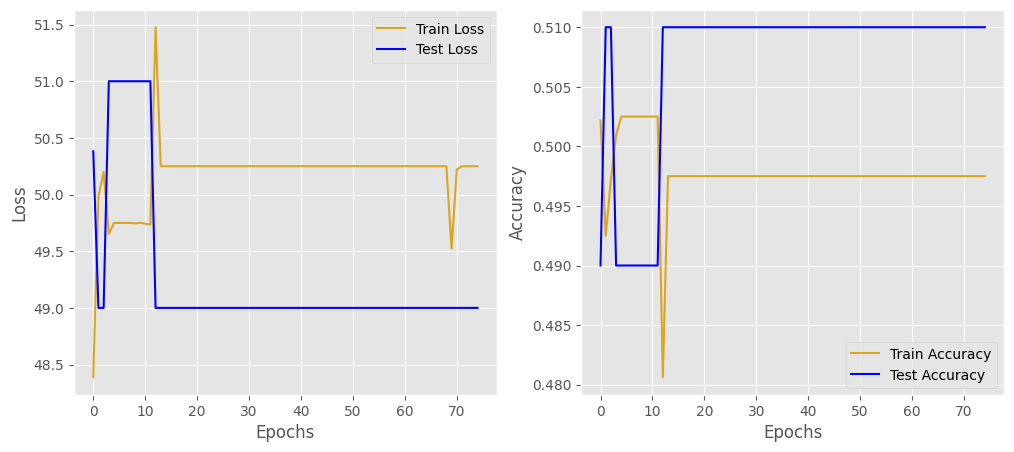

In [ ]:
# prompt: Before Hyperparameter Tuning: The highest test accuracy achieved was 79.87%.
# After Hyperparameter Tuning: The highest test accuracy achieved was 75.12%.
# rework on the hyper parameter tuning to get more than 79.87

import optuna

def objective(trial):
    # Hyperparameter search space
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256) # Increased search space
    num_layers = trial.suggest_int("num_layers", 2, 8) # Increased search space
    num_timesteps = trial.suggest_int("num_timesteps", 1, 5) # Increased search space
    dropout = trial.suggest_float("dropout", 0.0, 0.6) # Expanded range
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True) # Wider range
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True) # Wider range

    model = AttentiveFP(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                        edge_dim=3, num_layers=num_layers, num_timesteps=num_timesteps,
                        dropout=dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 50 # Increased epochs for evaluation within Optuna
    for epoch in range(epochs):
        train_loss, train_acc = train()

    test_loss, test_acc = test(test_loader)
    return test_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) # Increased number of trials

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Rerun with best hyperparameters
best_params = study.best_params
model = AttentiveFP(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
                    edge_dim=3, num_layers=best_params["num_layers"], num_timesteps=best_params["num_timesteps"],
                    dropout=best_params["dropout"]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

epochs = 75 # Original number of epochs
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []

for epoch in range(epochs):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, c='goldenrod')
plt.plot(range(epochs), score_test_loss, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, c='goldenrod')
plt.plot(range(epochs), score_test_acc, c='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


[I 2024-11-06 10:49:23,182] A new study created in memory with name: no-name-4f0fa2ef-2258-4533-97a8-6bee83ac2a95
[I 2024-11-06 10:49:59,129] Trial 0 finished with value: 0.74875 and parameters: {'hidden_channels': 82, 'num_layers': 4, 'num_timesteps': 1, 'dropout': 0.4219447562652072, 'learning_rate': 0.0011538069080450188, 'weight_decay': 2.0561945737995806e-05}. Best is trial 0 with value: 0.74875.
[I 2024-11-06 10:50:32,988] Trial 1 finished with value: 0.77625 and parameters: {'hidden_channels': 54, 'num_layers': 3, 'num_timesteps': 2, 'dropout': 0.2776978442152964, 'learning_rate': 0.000137116938119095, 'weight_decay': 5.961582272185435e-06}. Best is trial 1 with value: 0.77625.
[I 2024-11-06 10:51:06,891] Trial 2 finished with value: 0.7875 and parameters: {'hidden_channels': 74, 'num_layers': 6, 'num_timesteps': 3, 'dropout': 0.45570602702405605, 'learning_rate': 0.003022383708120549, 'weight_decay': 2.5204924295936306e-05}. Best is trial 2 with value: 0.7875.
[I 2024-11-06 10:

Best hyperparameters: {'hidden_channels': 126, 'num_layers': 5, 'num_timesteps': 3, 'dropout': 0.12141183084247242, 'learning_rate': 0.0006404262136175374, 'weight_decay': 2.7370201513408873e-06}
Best accuracy: 0.79875
Epoch: 000, Train Loss: 0.6742, Train Accuracy: 0.5750, Test Loss: 0.6169, Test Accuracy: 0.7250
Epoch: 001, Train Loss: 0.6078, Train Accuracy: 0.6847, Test Loss: 0.5821, Test Accuracy: 0.7063
Epoch: 002, Train Loss: 0.5760, Train Accuracy: 0.7106, Test Loss: 0.5508, Test Accuracy: 0.7400
Epoch: 003, Train Loss: 0.5682, Train Accuracy: 0.7091, Test Loss: 0.5536, Test Accuracy: 0.7362
Epoch: 004, Train Loss: 0.5524, Train Accuracy: 0.7247, Test Loss: 0.5438, Test Accuracy: 0.7338
Epoch: 005, Train Loss: 0.5466, Train Accuracy: 0.7359, Test Loss: 0.5436, Test Accuracy: 0.7412
Epoch: 006, Train Loss: 0.5480, Train Accuracy: 0.7281, Test Loss: 0.5303, Test Accuracy: 0.7512
Epoch: 007, Train Loss: 0.5334, Train Accuracy: 0.7394, Test Loss: 0.5788, Test Accuracy: 0.7300
Epoch

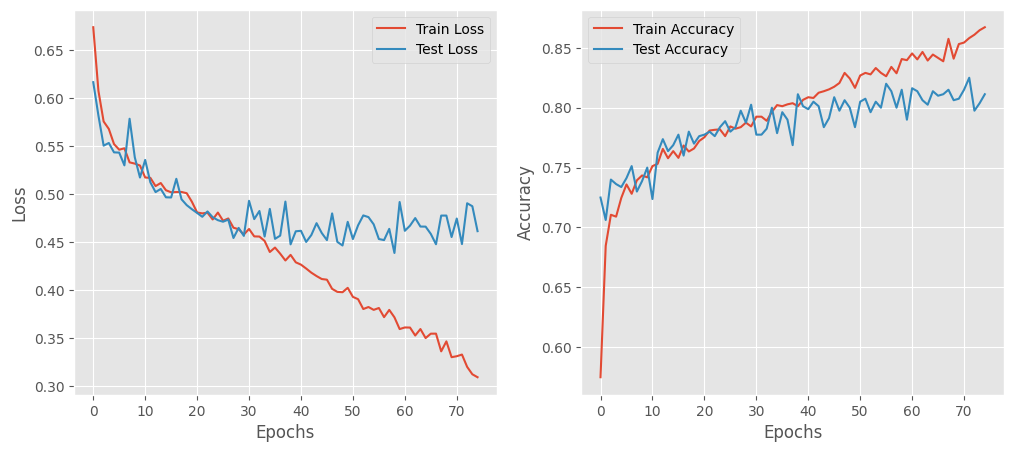

In [ ]:
# Install Optuna
!pip install --quiet optuna

import optuna
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Objective function for hyperparameter optimization
def objective(trial):
    # Define hyperparameter search space
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 3, 6)
    num_timesteps = trial.suggest_int("num_timesteps", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Initialize model and optimizer with trial parameters
    model = AttentiveFP(
        in_channels=9, hidden_channels=hidden_channels, out_channels=1,
        edge_dim=3, num_layers=num_layers, num_timesteps=num_timesteps,
        dropout=dropout
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop within the objective function
    epochs = 20  # Reduced epochs for faster optimization
    for epoch in range(epochs):
        train_loss, train_acc = train()  # Ensure train() moves data to device if required

    # Evaluate on test set
    test_loss, test_acc = test(test_loader)  # Ensure test_loader data is moved to device if needed
    return test_acc  # Objective is to maximize test accuracy

# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Number of trials

# Print best hyperparameters and accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Rerun with best hyperparameters
best_params = study.best_params
model = AttentiveFP(
    in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
    edge_dim=3, num_layers=best_params["num_layers"], num_timesteps=best_params["num_timesteps"],
    dropout=best_params["dropout"]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

# Set the number of epochs for the final run
epochs = 75
score_train_loss, score_train_acc = [], []
score_test_loss, score_test_acc = [], []

for epoch in range(epochs):
    train_loss, train_acc = train()  # Ensure train() moves data to device if required
    test_loss, test_acc = test(test_loader)  # Ensure test_loader data is moved to device if needed

    # Collect scores for plotting
    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: for the above training give the best train score and test score

best_train_accuracy = max(score_train_acc)
best_test_accuracy = max(score_test_acc)

print(f"Best Train Accuracy: {best_train_accuracy:.4f}")
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")

Best Train Accuracy: 0.8672
Best Test Accuracy: 0.8250


In [ ]:
# prompt: Best hyperparameters: {'hidden_channels': 126, 'num_layers': 5, 'num_timesteps': 3, 'dropout': 0.12141183084247242, 'learning_rate': 0.0006404262136175374, 'weight_decay': 2.7370201513408873e-06}
# Best accuracy: 0.79875
# what is Best accuracy here? is it related to best train score and test score

best_train_accuracy = max(score_train_acc)
best_test_accuracy = max(score_test_acc)

print(f"Best Train Accuracy: {best_train_accuracy:.4f}")
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")